In [106]:
#References: 
#https://www.youtube.com/watch?v=j05UUs99eNQ&list=RDCMUCtxCXg-UvSnTKPOzLH4wJaQ&index=4
#https://www.youtube.com/watch?v=2XGSIlgUBDI 
#https://github.com/nachi-hebbar/Time-Series-Forecasting-MachineLearning/blob/main/Time_Series_Forecasting_ML.ipynb

# https://towardsdatascience.com/5-machine-learning-techniques-for-sales-forecasting-598e4984b109#:~:text=Sales%20forecasts%20can%20be%20used,ML%20models%20to%20predict%20sales.

# https://towardsdatascience.com/time-series-forecasting-with-machine-learning-b3072a5b44ba

# https://github.com/mollyliebeskind/sales_forecasting/blob/master/models.py

# Supervised Timeseries forecasting - Random Forest Regressor

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.pandas.set_option("display.max_columns",None)


#Plotting
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

from statsmodels.tsa.ar_model import AutoReg

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Dataset

In [6]:
#df = pd.read_csv(r'C:\Users\saksh\OneDrive\Desktop\ML\PROJECT\sales_predict.csv')
df_purchases= pd.read_csv(r'C:\Users\saksh\OneDrive\Desktop\ML\PROJECT\ABT_final_forecast.csv')
df_purchases.head(5)

t_dat product_group_name graphical_appearance_name colour_group_name  \
0  2018-09-20        Accessories          All over pattern             Beige   
1  2018-09-20        Accessories          All over pattern             Black   
2  2018-09-20        Accessories          All over pattern             Black   
3  2018-09-20        Accessories          All over pattern             Black   
4  2018-09-20        Accessories          All over pattern             Black   

    department_name  count_purchases  
0      Knit & Woven                9  
1              Bags               21  
2  Hair Accessories                7  
3      Knit & Woven                3  
4  Ladies Sport Acc                5

In [7]:
#Aggregate on the basis of date, product and create aggregate column sales
#Merge dataframes to create aggregate of count of purchases made
df = df.groupby(['t_dat','product_group_name']).t_dat.count().reset_index(name='sales')
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9679 entries, 0 to 9678
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   t_dat               9679 non-null   object
 1   product_group_name  9679 non-null   object
 2   sales               9679 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 227.0+ KB


In [8]:
df

t_dat   product_group_name  sales
0     2018-09-20          Accessories    396
1     2018-09-20                 Bags      1
2     2018-09-20             Cosmetic      3
3     2018-09-20    Garment Full body    568
4     2018-09-20   Garment Lower body    876
...          ...                  ...    ...
9674  2020-09-22       Socks & Tights    128
9675  2020-09-22             Swimwear     63
9676  2020-09-22            Underwear    190
9677  2020-09-22  Underwear/nightwear      1
9678  2020-09-22              Unknown     47

[9679 rows x 3 columns]

In [9]:
#Rename columns
#df.rename(columns = {'m_y':'date'}, inplace = True)
df.rename(columns = {'product_group_name':'product'}, inplace = True)
df.rename(columns = {'t_dat':'date'}, inplace = True)


In [10]:
df.head(10)

date             product  sales
0  2018-09-20         Accessories    396
1  2018-09-20                Bags      1
2  2018-09-20            Cosmetic      3
3  2018-09-20   Garment Full body    568
4  2018-09-20  Garment Lower body    876
5  2018-09-20  Garment Upper body   2102
6  2018-09-20               Items      1
7  2018-09-20           Nightwear     95
8  2018-09-20               Shoes    202
9  2018-09-20      Socks & Tights    180

# Time Series Visualisation of data for day and sales

- Dataframe : df
- 2 columns : Date and Sales
- Forecast sales on upcoming days

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


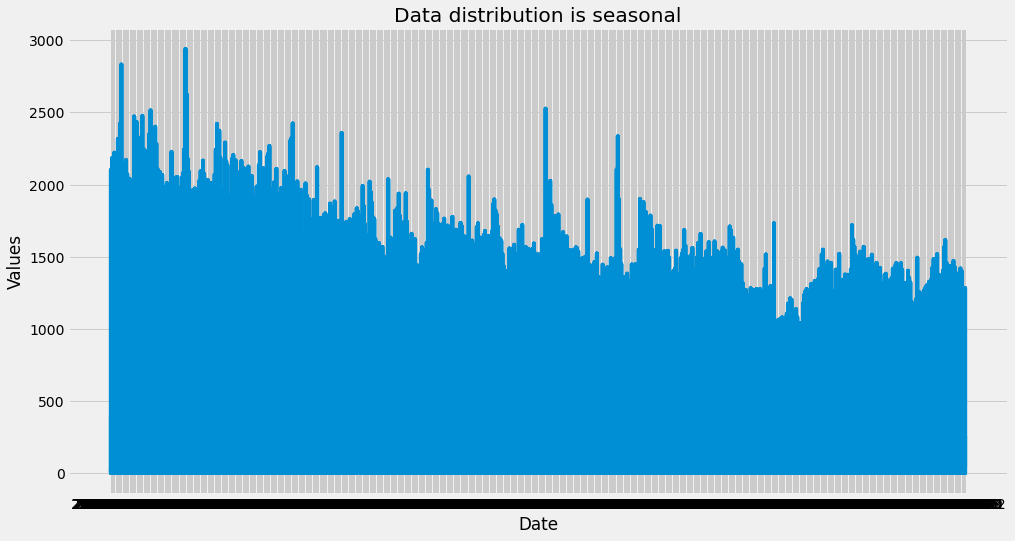

In [11]:
import matplotlib.pyplot as plt


# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("fivethirtyeight")

# setting figure size to 12, 10
plt.figure(figsize=(15, 8))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Data distribution is seasonal")

# plotting the "A" column alone
plt.plot(df['date'], df["sales"])


In [14]:

fig = px.line(
    data_frame = df.reset_index(),
    x      = 'date',
    y      = 'sales',
    title  = 'Sales',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()



In [15]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['sales'])


In [16]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [17]:
adfuller_test(df['sales'])

ADF Test Statistic : -6.6356387680777535
p-value : 5.571874834889491e-09
#Lags Used : 38
Number of Observations Used : 9640
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [28]:
#data is stationary.

# Create Autocorrelation plots

Need to check no. of lags(previous day's data) that need to be considered to forecast prediction for a particular day. 
This can be done by using auto-correlation plot. 

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

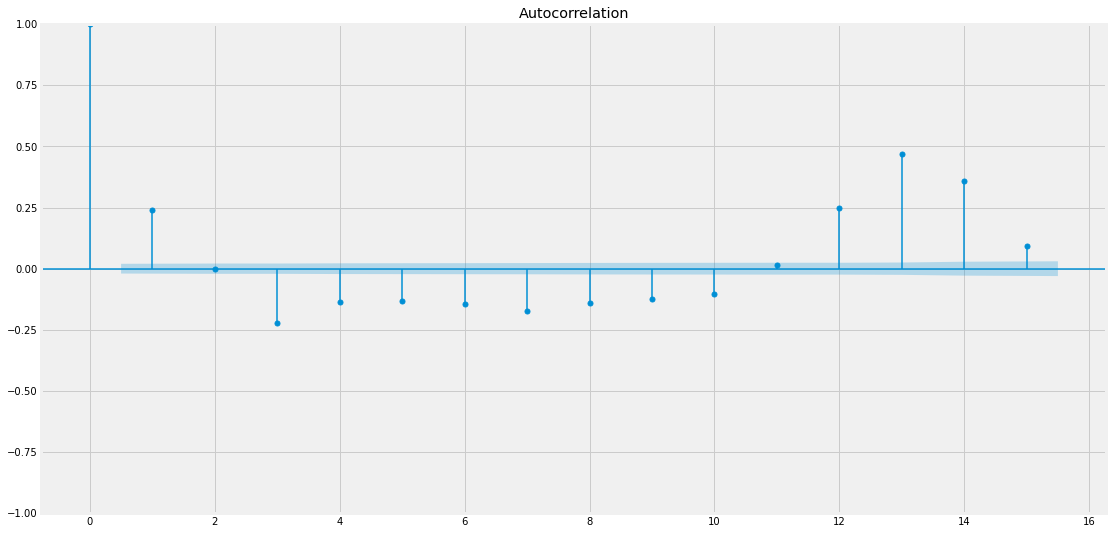

In [19]:
#plotting autocorrelation

fig, ax = plt.subplots(figsize=(17, 9))
plot_acf(df['sales'], ax=ax, lags=15)
plt.show()

In [20]:
acf_values = acf(df['sales'])


In [21]:
np.round(acf_values, 2)

array([ 1.  ,  0.24,  0.  , -0.22, -0.14, -0.13, -0.15, -0.17, -0.14,
       -0.12, -0.1 ,  0.01,  0.25,  0.47,  0.36,  0.09, -0.08, -0.14,
       -0.15, -0.15, -0.15, -0.13, -0.09, -0.04,  0.04,  0.18,  0.26,
        0.26,  0.13, -0.  , -0.07, -0.12, -0.13, -0.12, -0.11, -0.07,
       -0.02,  0.04,  0.13,  0.17])

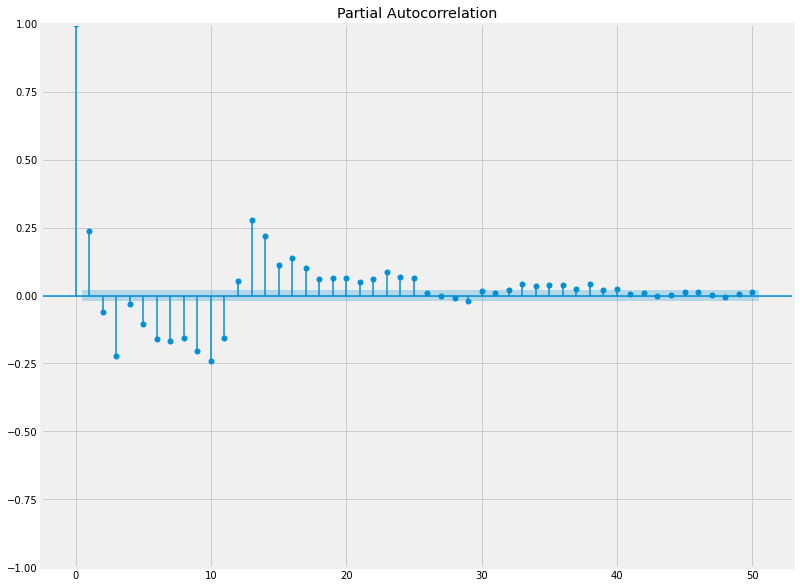

In [22]:
#plotting partial autocorrelation

fig, ax = plt.subplots(figsize=(12, 10))
plot_pacf(df['sales'], ax=ax, lags=50,method='ywm')
plt.show()

In [23]:
pacf_values = pacf(df['sales'])

In [24]:
np.round(pacf_values, 2)

array([ 1.  ,  0.24, -0.06, -0.22, -0.03, -0.11, -0.16, -0.17, -0.16,
       -0.2 , -0.24, -0.16,  0.05,  0.28,  0.22,  0.11,  0.14,  0.1 ,
        0.06,  0.06,  0.06,  0.05,  0.06,  0.09,  0.07,  0.06,  0.01,
       -0.  , -0.01, -0.02,  0.02,  0.01,  0.02,  0.04,  0.04,  0.04,
        0.04,  0.02,  0.04,  0.02])

In [25]:
df= df.set_index('date')

In [26]:
df

product  sales
date                                  
2018-09-20          Accessories    396
2018-09-20                 Bags      1
2018-09-20             Cosmetic      3
2018-09-20    Garment Full body    568
2018-09-20   Garment Lower body    876
...                         ...    ...
2020-09-22       Socks & Tights    128
2020-09-22             Swimwear     63
2020-09-22            Underwear    190
2020-09-22  Underwear/nightwear      1
2020-09-22              Unknown     47

[9679 rows x 2 columns]

# Create automatic lags

In [27]:
def generate_supervised(data):
    supervised_df = data
    
    #create column for each lag
    for i in range(1,15):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['sales'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=False)
    supervised_df.to_csv(r'C:\Users\saksh\OneDrive\Desktop\ML\PROJECT\all_features_lags_v1.csv', index=False)
    
    return supervised_df


In [28]:
df_lag = generate_supervised(df)

In [29]:
df_lag

date              product  sales  lag_1  lag_2  lag_3   lag_4  \
0     2018-09-21          Accessories    404    6.0    2.0  241.0    98.0   
1     2018-09-21             Cosmetic      4  404.0    6.0    2.0   241.0   
2     2018-09-21    Garment Full body    545    4.0  404.0    6.0     2.0   
3     2018-09-21   Garment Lower body    895  545.0    4.0  404.0     6.0   
4     2018-09-21   Garment Upper body   2184  895.0  545.0    4.0   404.0   
...          ...                  ...    ...    ...    ...    ...     ...   
9660  2020-09-22       Socks & Tights    128   84.0   60.0   10.0  1284.0   
9661  2020-09-22             Swimwear     63  128.0   84.0   60.0    10.0   
9662  2020-09-22            Underwear    190   63.0  128.0   84.0    60.0   
9663  2020-09-22  Underwear/nightwear      1  190.0   63.0  128.0    84.0   
9664  2020-09-22              Unknown     47    1.0  190.0   63.0   128.0   

       lag_5   lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  lag_13  \
0      180.0   202.0    95.0     1.0  2102.0   876.0   568.0     3.0     1.0   
1       98.0   180.0   202.0    95.0     1.0  2102.0   876.0   568.0     3.0   
2      241.0    98.0   180.0   202.0    95.0     1.0  2102.0   876.0   568.0   
3        2.0   241.0    98.0   180.0   202.0    95.0     1.0  2102.0   876.0   
4        6.0     2.0   241.0    98.0   180.0   202.0    95.0     1.0  2102.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
9660   625.0   408.0     4.0   256.0    49.0   174.0    67.0   132.0    77.0   
9661  1284.0   625.0   408.0     4.0   256.0    49.0   174.0    67.0   132.0   
9662    10.0  1284.0   625.0   408.0     4.0   256.0    49.0   174.0    67.0   
9663    60.0    10.0  1284.0   625.0   408.0     4.0   256.0    49.0   174.0   
9664    84.0    60.0    10.0  1284.0   625.0   408.0     4.0   256.0    49.0   

      lag_14  
0      396.0  
1        1.0  
2        3.0  
3      568.0  
4      876.0  
...      ...  
9660    59.0  
9661    77.0  
9662   132.0  
9663    67.0  
9664   174.0  

[9665 rows x 17 columns]

In [48]:
df_lag.drop("index", axis=1, inplace=True)


KeyError: "['index'] not found in axis"

In [49]:
df= df.set_index('date')

KeyError: "None of ['date'] are in the columns"

# Data Preparation
Reference : https://www.youtube.com/watch?v=Wsfz3i1AXzY

In [31]:
features = ['lag_1', 'lag_2','lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',  'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14']
label = ['sales']
test_df = df_lag[df_lag['date'] >= '2020-07-01']
train_df = df_lag[df_lag['date'] < '2020-07-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [39]:
# train_df.to_csv(r'C:\Users\saksh\OneDrive\Desktop\ML\PROJECT\Iteration 2\train.csv', index=False)
# test_df.to_csv(r'C:\Users\saksh\OneDrive\Desktop\ML\PROJECT\Iteration 2\test.csv', index=False)


In [32]:
X_train

lag_1  lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  lag_8   lag_9  \
0       6.0    2.0   241.0    98.0   180.0   202.0    95.0    1.0  2102.0   
1     404.0    6.0     2.0   241.0    98.0   180.0   202.0   95.0     1.0   
2       4.0  404.0     6.0     2.0   241.0    98.0   180.0  202.0    95.0   
3     545.0    4.0   404.0     6.0     2.0   241.0    98.0  180.0   202.0   
4     895.0  545.0     4.0   404.0     6.0     2.0   241.0   98.0   180.0   
...     ...    ...     ...     ...     ...     ...     ...    ...     ...   
8523   62.0    3.0  1448.0   924.0   735.0     1.0     1.0    2.0   366.0   
8524  166.0   62.0     3.0  1448.0   924.0   735.0     1.0    1.0     2.0   
8525   96.0  166.0    62.0     3.0  1448.0   924.0   735.0    1.0     1.0   
8526  181.0   96.0   166.0    62.0     3.0  1448.0   924.0  735.0     1.0   
8527  220.0  181.0    96.0   166.0    62.0     3.0  1448.0  924.0   735.0   

      lag_10  lag_11  lag_12  lag_13  lag_14  
0      876.0   568.0     3.0     1.0   396.0  
1     2102.0   876.0   568.0     3.0     1.0  
2        1.0  2102.0   876.0   568.0     3.0  
3       95.0     1.0  2102.0   876.0   568.0  
4      202.0    95.0     1.0  2102.0   876.0  
...      ...     ...     ...     ...     ...  
8523    35.0   199.0   173.0     1.0   108.0  
8524   366.0    35.0   199.0   173.0     1.0  
8525     2.0   366.0    35.0   199.0   173.0  
8526     1.0     2.0   366.0    35.0   199.0  
8527     1.0     1.0     2.0   366.0    35.0  

[8528 rows x 14 columns]

In [34]:
X_test

lag_1  lag_2  lag_3   lag_4   lag_5   lag_6   lag_7   lag_8   lag_9  \
8528   34.0  220.0  181.0    96.0   166.0    62.0     3.0  1448.0   924.0   
8529  359.0   34.0  220.0   181.0    96.0   166.0    62.0     3.0  1448.0   
8530    2.0  359.0   34.0   220.0   181.0    96.0   166.0    62.0     3.0   
8531    2.0    2.0  359.0    34.0   220.0   181.0    96.0   166.0    62.0   
8532    1.0    2.0    2.0   359.0    34.0   220.0   181.0    96.0   166.0   
...     ...    ...    ...     ...     ...     ...     ...     ...     ...   
9660   84.0   60.0   10.0  1284.0   625.0   408.0     4.0   256.0    49.0   
9661  128.0   84.0   60.0    10.0  1284.0   625.0   408.0     4.0   256.0   
9662   63.0  128.0   84.0    60.0    10.0  1284.0   625.0   408.0     4.0   
9663  190.0   63.0  128.0    84.0    60.0    10.0  1284.0   625.0   408.0   
9664    1.0  190.0   63.0   128.0    84.0    60.0    10.0  1284.0   625.0   

      lag_10  lag_11  lag_12  lag_13  lag_14  
8528   735.0     1.0     1.0     2.0   366.0  
8529   924.0   735.0     1.0     1.0     2.0  
8530  1448.0   924.0   735.0     1.0     1.0  
8531     3.0  1448.0   924.0   735.0     1.0  
8532    62.0     3.0  1448.0   924.0   735.0  
...      ...     ...     ...     ...     ...  
9660   174.0    67.0   132.0    77.0    59.0  
9661    49.0   174.0    67.0   132.0    77.0  
9662   256.0    49.0   174.0    67.0   132.0  
9663     4.0   256.0    49.0   174.0    67.0  
9664   408.0     4.0   256.0    49.0   174.0  

[1137 rows x 14 columns]

# RandomForestRegressor - Baseline

In [35]:
#BASE MODEL
from sklearn.ensemble import RandomForestRegressor
rf_model=RandomForestRegressor(n_estimators=200,max_features=3, random_state=1)


In [36]:
rf_model.fit(X_train,y_train)

C:\Users\saksh\AppData\Local\Temp/ipykernel_24136/764246711.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_features=3, n_estimators=200, random_state=1)

In [37]:
pred=rf_model.predict(X_test)


In [38]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['pred'] = pd.Series(pred)

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


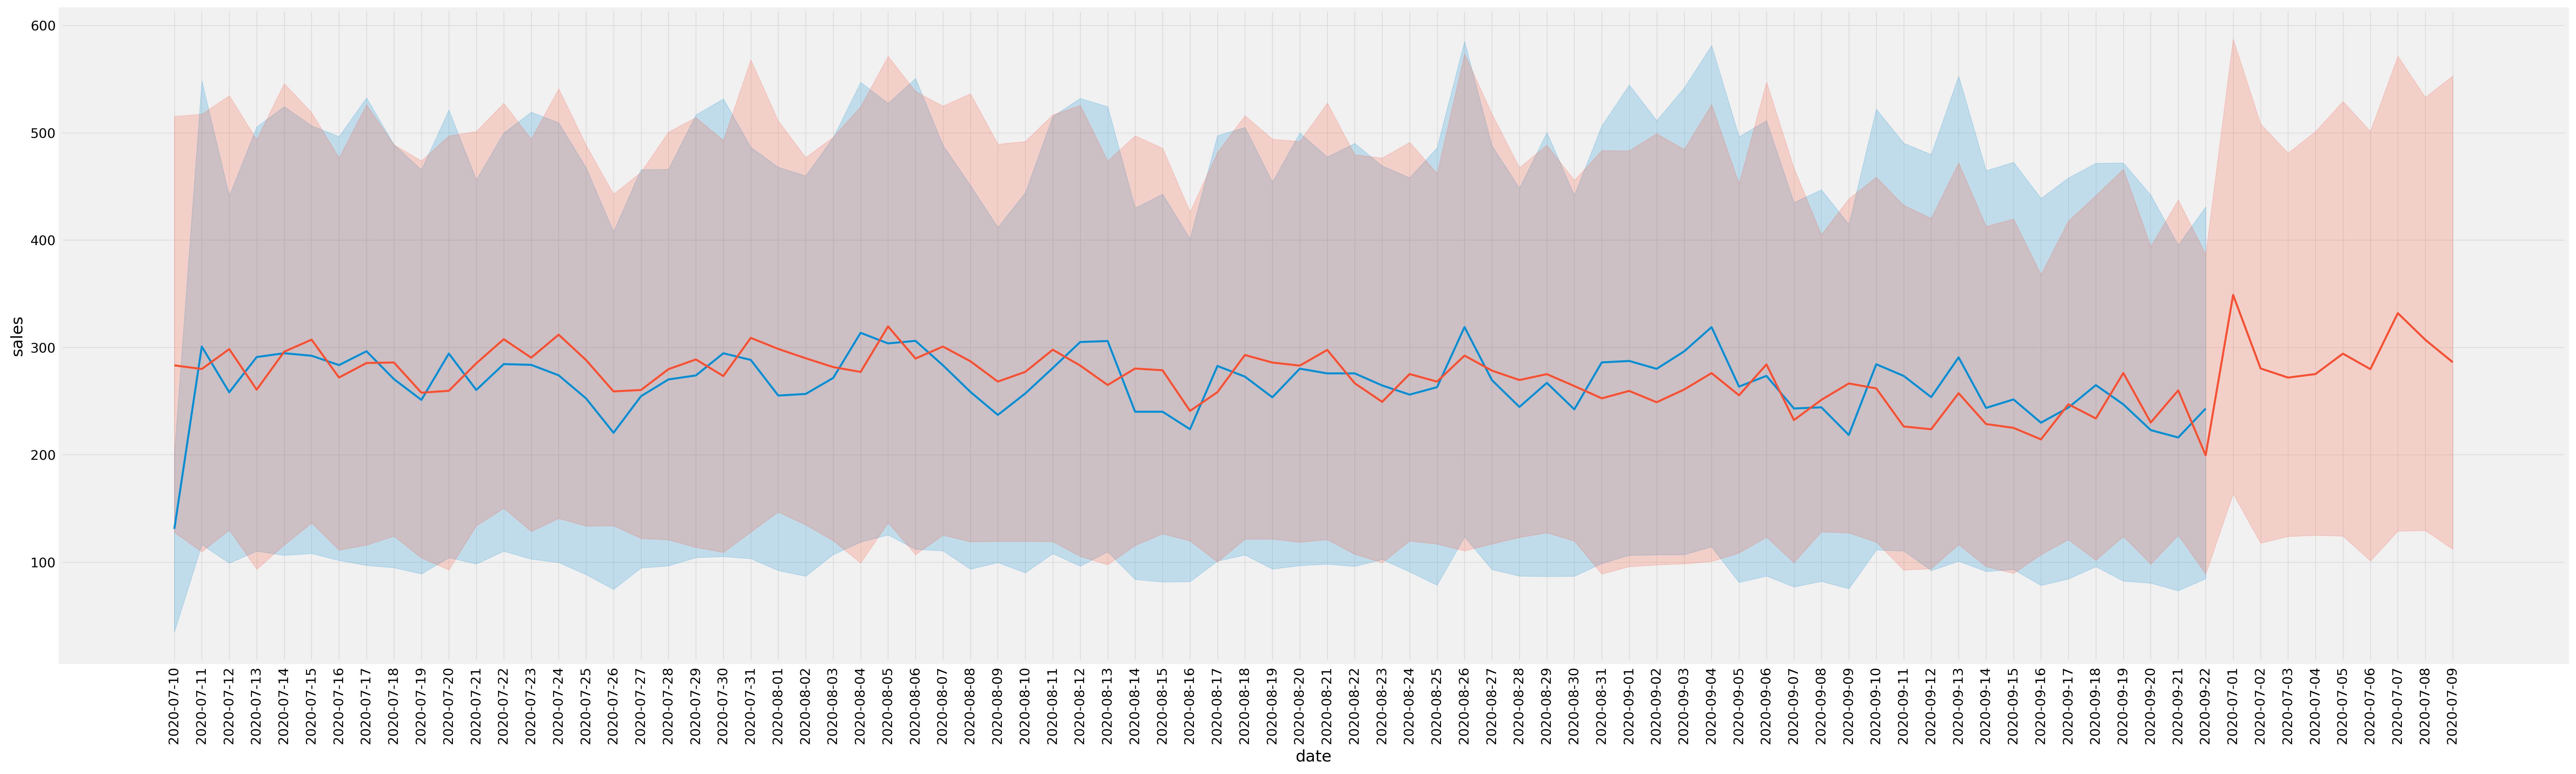

In [41]:
plt.rcParams.update({'figure.figsize': (30, 9), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df_lag.tail(1000), x='date', y='sales')
sns.lineplot(data=test_df, x='date', y='pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [42]:
test_df.head(30)

date             product  sales   lag_1   lag_2   lag_3   lag_4  \
0   2020-07-01         Accessories    359    34.0   220.0   181.0    96.0   
1   2020-07-01                Bags      2   359.0    34.0   220.0   181.0   
2   2020-07-01            Cosmetic      2     2.0   359.0    34.0   220.0   
3   2020-07-01           Furniture      1     2.0     2.0   359.0    34.0   
4   2020-07-01   Garment Full body    733     1.0     2.0     2.0   359.0   
5   2020-07-01  Garment Lower body    934   733.0     1.0     2.0     2.0   
6   2020-07-01  Garment Upper body   1485   934.0   733.0     1.0     2.0   
7   2020-07-01               Items      3  1485.0   934.0   733.0     1.0   
8   2020-07-01           Nightwear     61     3.0  1485.0   934.0   733.0   
9   2020-07-01               Shoes    172    61.0     3.0  1485.0   934.0   
10  2020-07-01      Socks & Tights    116   172.0    61.0     3.0  1485.0   
11  2020-07-01          Stationery      1   116.0   172.0    61.0     3.0   
12  2020-07-01            Swimwear    187     1.0   116.0   172.0    61.0   
13  2020-07-01           Underwear    213   187.0     1.0   116.0   172.0   
14  2020-07-01             Unknown     35   213.0   187.0     1.0   116.0   
15  2020-07-02         Accessories    362    35.0   213.0   187.0     1.0   
16  2020-07-02                Bags      2   362.0    35.0   213.0   187.0   
17  2020-07-02            Cosmetic      1     2.0   362.0    35.0   213.0   
18  2020-07-02   Garment Full body    682     1.0     2.0   362.0    35.0   
19  2020-07-02  Garment Lower body    891   682.0     1.0     2.0   362.0   
20  2020-07-02  Garment Upper body   1478   891.0   682.0     1.0     2.0   
21  2020-07-02               Items      3  1478.0   891.0   682.0     1.0   
22  2020-07-02           Nightwear     62     3.0  1478.0   891.0   682.0   
23  2020-07-02               Shoes    163    62.0     3.0  1478.0   891.0   
24  2020-07-02      Socks & Tights    116   163.0    62.0     3.0  1478.0   
25  2020-07-02          Stationery      1   116.0   163.0    62.0     3.0   
26  2020-07-02            Swimwear    176     1.0   116.0   163.0    62.0   
27  2020-07-02           Underwear    206   176.0     1.0   116.0   163.0   
28  2020-07-02             Unknown     33   206.0   176.0     1.0   116.0   
29  2020-07-03         Accessories    352    33.0   206.0   176.0     1.0   

     lag_5   lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  lag_13  \
0    166.0    62.0     3.0  1448.0   924.0   735.0     1.0     1.0     2.0   
1     96.0   166.0    62.0     3.0  1448.0   924.0   735.0     1.0     1.0   
2    181.0    96.0   166.0    62.0     3.0  1448.0   924.0   735.0     1.0   
3    220.0   181.0    96.0   166.0    62.0     3.0  1448.0   924.0   735.0   
4     34.0   220.0   181.0    96.0   166.0    62.0     3.0  1448.0   924.0   
5    359.0    34.0   220.0   181.0    96.0   166.0    62.0     3.0  1448.0   
6      2.0   359.0    34.0   220.0   181.0    96.0   166.0    62.0     3.0   
7      2.0     2.0   359.0    34.0   220.0   181.0    96.0   166.0    62.0   
8      1.0     2.0     2.0   359.0    34.0   220.0   181.0    96.0   166.0   
9    733.0     1.0     2.0     2.0   359.0    34.0   220.0   181.0    96.0   
10   934.0   733.0     1.0     2.0     2.0   359.0    34.0   220.0   181.0   
11  1485.0   934.0   733.0     1.0     2.0     2.0   359.0    34.0   220.0   
12     3.0  1485.0   934.0   733.0     1.0     2.0     2.0   359.0    34.0   
13    61.0     3.0  1485.0   934.0   733.0     1.0     2.0     2.0   359.0   
14   172.0    61.0     3.0  1485.0   934.0   733.0     1.0     2.0     2.0   
15   116.0   172.0    61.0     3.0  1485.0   934.0   733.0     1.0     2.0   
16     1.0   116.0   172.0    61.0     3.0  1485.0   934.0   733.0     1.0   
17   187.0     1.0   116.0   172.0    61.0     3.0  1485.0   934.0   733.0   
18   213.0   187.0     1.0   116.0   172.0    61.0     3.0  1485.0   934.0   
19    35.0   213.0   187.0     1.0   116.0   172.0    61.0    

In [43]:
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))
print('Mean Squared Error for XGBoost is:',rmse_rf)

Mean Squared Error for XGBoost is: 109.25837280819229


In [44]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_test,pred))

MAE 66.24894019349165


In [45]:
print("RMSE",np.log(np.sqrt(mean_squared_error(y_test,pred))))


RMSE 4.693715470015672


In [46]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,pred)
print(r2)

0.9166996157513513


In [47]:
n=30712
k=9
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print(adj_r2_score)

0.9166751970340613


# Grid Search CV

In [40]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [41]:
# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}